In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Recap clustering

## KMeans

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


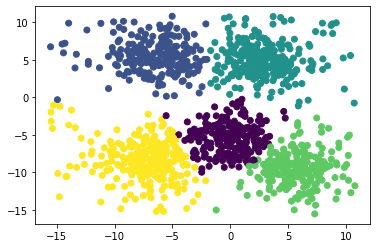

In [2]:
from sklearn.cluster import KMeans


# Generate random data
data = np.random.rand(100, 2)

data, y = make_blobs(1000,cluster_std=2.0, centers=5,random_state=10 )

random = np.random.RandomState(5)
noise = (data.max()-data.min())*random.rand(200,2)+data.min()

data = np.concatenate((data,noise))

# Create KMeans object with 3 clusters
kmeans = KMeans(n_clusters=5)

# Fit KMeans object to data
kmeans.fit(data)

# Predict cluster labels for data
labels_kmeans = kmeans.predict(data)

# Visualize results
import matplotlib.pyplot as plt

plt.scatter(data[:,0], data[:,1], c=labels_kmeans);

## Hierarchical

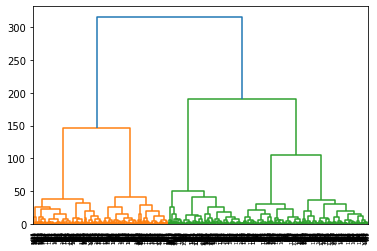

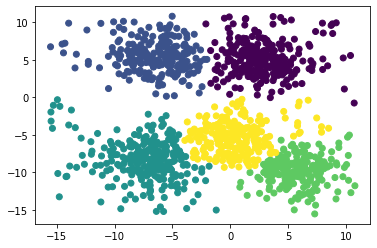

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute linkage matrix using Ward's method
Z = linkage(data, method='ward')

# Plot dendrogram
dendrogram(Z)
plt.show()

# Cut dendrogram at height 3 to obtain clusters
from scipy.cluster.hierarchy import fcluster

labels_hierarchical = fcluster(Z, 90, criterion='distance')

# Visualize results
plt.scatter(data[:,0], data[:,1], c=labels_hierarchical);

## DBSCAN

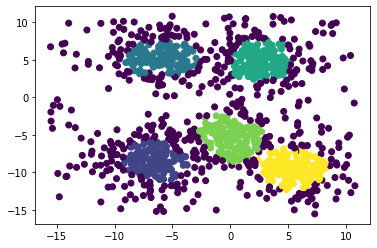

In [4]:
from sklearn.cluster import DBSCAN

# Create DBSCAN object with epsilon=0.1 and min_samples=5
dbscan = DBSCAN(eps=1.35, min_samples=35)

# Fit DBSCAN object to data
dbscan.fit(data)

# Predict cluster labels for data (-1 denotes noise points)
labels_dbscan = dbscan.labels_

# Visualize results
plt.scatter(data[:,0], data[:,1], c=labels_dbscan);

In [5]:
np.unique(labels_dbscan, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([492, 135, 132, 140, 147, 154]))

In [6]:
np.unique(labels_hierarchical, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([251, 235, 267, 212, 235]))

In [7]:
np.unique(labels_kmeans, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([219, 237, 253, 231, 260]))

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
accuracy_score(labels_hierarchical, labels_kmeans)

0.0016666666666666668

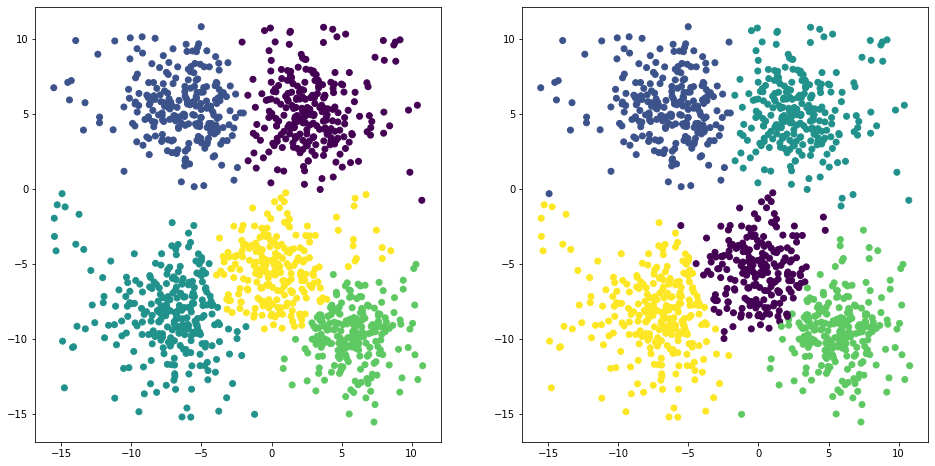

In [13]:
# Visualize results
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].scatter(data[:,0], data[:,1], c=labels_hierarchical);
axs[1].scatter(data[:,0], data[:,1], c=labels_kmeans);

# Rand Index

The Rand Index is calculated using the following formula: 

$$ \text{RI} = \frac{a + b}{a + b + c + d} $$

    a: The number of pairs of elements that are in the same subset in both clusterings.
    b: The number of pairs of elements that are in different subsets in both clusterings.
    c: The number of pairs of elements that are in the same subset in the first clustering but in different subsets in the second clustering.
    d: The number of pairs of elements that are in different subsets in the first clustering but in the same subset in the second clustering.


## Mirkin's Index
$$a+b$$

In [ ]:
n

n * n / 2 - n = n (n-1) / 2 = a+b+c+d

In [ ]:
0,1,2,3

In [ ]:
x = [0,0,1,1]
y = [0,1,1,1]


accuracy(x, y) # 3/4 = 0.75

x = 

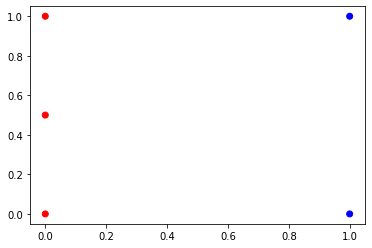

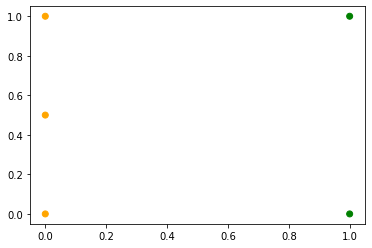

In [19]:
plt.scatter([0, 0,0, 1, 1], [0,1,0.5,0,1], c=['r', 'r','r', 'b', 'b'])
plt.figure()
plt.scatter([0, 0,0, 1, 1], [0,1,0.5,0,1], c=['orange', 'orange','orange', 'g', 'g'])

In [ ]:
x = ['g','g','r','r']
y = ['w','k','k','k']

all_pairs = [
    (0,1),
    (0,2),
    (0,3),
    (1,2),
    (1,3), # 
    (2,3) # a+1
]

a = ...
b = ...
c = ...
d = ...

In [20]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scipy.sparse as sp

In [21]:
def contingency_matrix(
    labels_true, labels_pred, *, eps=None, sparse=False, dtype=np.int64
):
  
    if eps is not None and sparse:
        raise ValueError("Cannot set 'eps' when sparse=True")

    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    # Using coo_matrix to accelerate simple histogram calculation,
    # i.e. bins are consecutive integers
    # Currently, coo_matrix is faster than histogram2d for simple cases
    contingency = sp.coo_matrix(
        (np.ones(class_idx.shape[0]), (class_idx, cluster_idx)),
        shape=(n_classes, n_clusters),
        dtype=dtype,
    )
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            # don't use += as contingency is integer
            contingency = contingency + eps
    return contingency

In [22]:
def pair_confusion_matrix(labels_true, labels_pred):
    n_samples = np.int64(labels_true.shape[0])

    # Computation using the contingency data
    contingency = contingency_matrix(
        labels_true, labels_pred, sparse=True, dtype=np.int64
    )
    n_c = np.ravel(contingency.sum(axis=1))
    n_k = np.ravel(contingency.sum(axis=0))
    sum_squares = (contingency.data**2).sum()
    C = np.empty((2, 2), dtype=np.int64)
    C[1, 1] = sum_squares - n_samples
    C[0, 1] = contingency.dot(n_k).sum() - sum_squares
    C[1, 0] = contingency.transpose().dot(n_c).sum() - sum_squares
    C[0, 0] = n_samples**2 - C[0, 1] - C[1, 0] - sum_squares
    return C

In [23]:
def rand_index(labels_true, labels_pred):
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)
    # convert to Python integer types, to avoid overflow or underflow
    tn, fp, fn, tp = int(tn), int(fp), int(fn), int(tp)
    return (tp+tn)/(tn+fp+fn+tp)

In [25]:
accuracy_score(labels_kmeans, labels_hierarchical)

0.0016666666666666668

In [24]:
rand_index(labels_kmeans, labels_hierarchical)

0.981976647206005

In [26]:
adjusted_rand_score(labels_kmeans, labels_hierarchical)

0.9437403501957891

In [27]:
adjusted_mutual_info_score(labels_kmeans, labels_hierarchical) # normalized mutual information

0.935823600086773

## Why do we need an "adjusted" Rand index?

In [28]:
y_true = np.array([0] * 240 + [1] * 240 + [2]*240 + [3] * 240 + [4] *240)

In [33]:
y_true[:40]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
y_random = random.randint(0,5,1200)

In [32]:
y_random[:40]

array([4, 2, 3, 4, 0, 3, 4, 1, 4, 3, 2, 4, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2,
       0, 1, 0, 4, 0, 2, 1, 3, 4, 2, 2, 3, 4, 0, 4, 4, 4, 3])

In [34]:
rand_index(y_true, y_random)

0.6802515985543508

In [35]:
adjusted_rand_score(y_true, y_random)

-0.0006093143118824871

In [36]:
adjusted_mutual_info_score(y_true, y_random)

-0.0005699704166265841

## Toy example 2 clusters

In [37]:
clusters = [0]*50 + [1]*50
print(clusters)
clusters = np.array(clusters)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [38]:
def shuffle_clusters(n1, n2, probability=0.1):
    cluster_1 = np.random.rand(n1)
    cluster_1 = (cluster_1 < probability).astype(int)
    cluster_2 = np.random.rand(n2)
    cluster_2 = (cluster_2 > probability).astype(int)
    return np.array(list(cluster_1) + list(cluster_2))

In [39]:
from tqdm.notebook import tqdm

In [40]:
aris = []
ris = []
amis = []
for probability in tqdm(np.linspace(0,0.5,50)):
    predicted_clusters = shuffle_clusters(50, 50, probability)
    ris.append(rand_index(clusters, predicted_clusters))
    aris.append(adjusted_rand_score(clusters, predicted_clusters))
    amis.append(adjusted_mutual_info_score(clusters, predicted_clusters))

  0%|          | 0/50 [00:00<?, ?it/s]

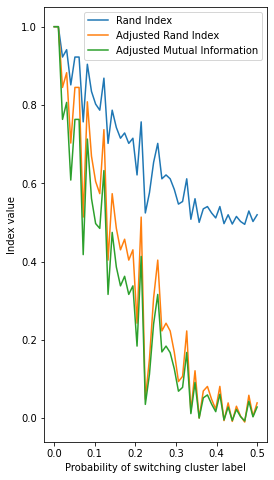

In [41]:
plt.figure(figsize=(4,8))
plt.plot(np.linspace(0,0.5,50), ris, label='Rand Index')
plt.plot(np.linspace(0,0.5,50), aris, label='Adjusted Rand Index')
plt.plot(np.linspace(0,0.5,50), amis, label='Adjusted Mutual Information')
plt.ylabel('Index value')
plt.xlabel('Probability of switching cluster label')
plt.legend();

## Everything goes worse as number of clusters increases

Check out "Systematic Analysis of Cluster Similarity Indices:
How to Validate Validation Measures" http://proceedings.mlr.press/v139/gosgens21a/gosgens21a.pdf

In [ ]:
Fuzzy Clustering
Overlapping clusters (communities)

In [ ]:
y_[N]

y_[NxK]

In [ ]:
Мультилейбл

пациент1 -> Грипп, Перелом
пациент2 -> Ковид
...
пациентN -> Инсульт, Пневмония